# Geostatistics and Reservoir Simulation

# Homework 1

# Alexey Topolnitskiy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Initializing starting conditions
gas_composition = {'Component': ['$CO_2$', '$N_2$', '$C_1$', '$C_2$', '$C_3$', '$i-C_4$', '$i-C_5$'], 
                   'y': [0.02, 0.01, 0.85, 0.04, 0.03, 0.03, 0.02]}
df_gas_composition = pd.DataFrame(data=gas_composition)
print('A gas reservoir has the following composition:')

df_gas_composition

A gas reservoir has the following composition:


,Component,y
0,$CO_2$,0.02
1,$N_2$,0.01
2,$C_1$,0.85
3,$C_2$,0.04
4,$C_3$,0.03
5,$i-C_4$,0.03
6,$i-C_5$,0.02


The initial reservoir pressure and temperature are 3000 $psia$ and 180 $^\circ F$ respectively, preset tolerance is $10^{-12}$.

In [3]:
init_pressure = 3000.
init_temperature = 180.
tolerance = 10**(-12)

### Task 1. Calculate the density of the gas mixture under the described condition.

#### Molar masses of the gas mixture components

Molar mass $Mol$ is a physical property defined as a given substance divided by the amount of substance. The base SI unit for molar mass is $\frac{kg}{mol}$. In this work I will use $\frac{lb}{lb-mol}$ unit.

To find a molar mass of a gas mixture we need summarize all multiplication of a molar mass of each component by its amount in the mixture.

* $Mol = \sum_{i=1}^{n}y_{i}Mol_{i}$,

where $n$ - number of components, 

$y_{i}$ - amount of a i-th component, 

$Mol_{i}$ - molar mass of a i-th component.

In [4]:
molar_masses = []

# Molar mass of the CO2
molar_masses.append(12.011 + 15.999 * 2)

# Molar mass of the N2
molar_masses.append(14.007 * 2)

# Molar mass of CnH(2n+2) components
for n in range(1, 6):
    molar_masses.append(12.011 * n + 1.0079 * (2 * n + 2))

# Adding received molar masses to the dataframe
df_gas_composition['Molar mass'] = molar_masses

df_gas_composition

,Component,y,Molar mass
0,$CO_2$,0.02,44.0090
1,$N_2$,0.01,28.0140
2,$C_1$,0.85,16.0426
3,$C_2$,0.04,30.0694
4,$C_3$,0.03,44.0962
5,$i-C_4$,0.03,58.1230
6,$i-C_5$,0.02,72.1498


#### Gas constant R

The gas constant is also known as the molar universal, or ideal gas constant, denoted by the symbol $R$. 

In Russia the gas constant is used equals to:
* $R = 8.31$ in $\frac{Pa \cdot m^{3}}{K \cdot mol}$

In West documentation and literature the gas constant equals to:
* $R = 10.73$ in $\frac{psia \cdot ft^{3}}{lb-mol \cdot  R}$

During the work I will use West unit for gas constant.

In [5]:
R = 10.73

#### Critical point

The critical point is the point at which all intensive properties of the gas and liquid phases are equal. The critical point is defined by critical pressure and critical temperature. We will need them in further calculations.

Critical temperature of the gas mixture can be obtained as following:
* $T_{pc}=\sum_{i}^{n} y_{i}T_{pci}$,

where $T_{pci}$ - critical temperature of the i-th gas component.

Critical pressure of the mixture:
* $p_{pc}=\sum_{i}^{n} y_{i}p_{pci}$,

where $p_{pci}$ - critical pressure of the i-th gas component.

In [6]:
# Critical temperatures of the gas mixture components in Fahrenheit
critical_temperatures = {'CO2': 87.9, 'N2': -232.5, 'CH4': -116.7, 'C2H6': 89.0,
                         'C3H8': 206.1, 'C4H10': 274.5, 'C5H12': 389.1}

# Critical pressures of the gas mixture components in psia
critical_pressures = {'CO2': 1071., 'N2': 493.1, 'CH4': 666.4, 'C2H6': 706.5,
                      'C3H8': 616.0, 'C4H10': 527.9, 'C5H12': 490.4}

In [7]:
# Adding critical temperatures and pressures to our dataframe
df_gas_composition['Critical temperature'] = list(critical_temperatures.values())
df_gas_composition['Critical pressure'] = list(critical_pressures.values())

df_gas_composition

,Component,y,Molar mass,Critical temperature,Critical pressure
0,$CO_2$,0.02,44.0090,87.9,1071.0
1,$N_2$,0.01,28.0140,-232.5,493.1
2,$C_1$,0.85,16.0426,-116.7,666.4
3,$C_2$,0.04,30.0694,89.0,706.5
4,$C_3$,0.03,44.0962,206.1,616.0
5,$i-C_4$,0.03,58.1230,274.5,527.9
6,$i-C_5$,0.02,72.1498,389.1,490.4


#### Compressibility factor Z

Hall and Yarborough (1973) proposed a mathematical form for calculating the Z-factor:
* $Z=\left[\frac{0.06125 \cdot p_{pr} \cdot t}{Y} \right]\exp[-1.2(1-t)^{2}]$

where $p_{pr}$ - pseudo-reduced pressure,

$t$ - reciprocal of the pseudo-reduced temperature, i.e. $\frac{T_{pc}}{T}$,

$Y$ - reduced density that can be obtained as the solution of the following equation:
* $F(Y)=A +\frac{Y+Y^2+Y^3+Y^4}{(1-Y)^3}-BY^2+CY^D=0$,

where $A = -0.06125 \cdot p_{pr} \cdot t \cdot \exp[-1.2(1-t)^2]$,

$B = 14.76t - 9.76t^2 + 4.58t^3$,

$C = 90.7t - 242.2t^2 + 42.4t^3$,

$D = 2.18 + 2.82t$.

The computational procedure considers several steps to find an optimum value of reduced density $Y$ and then use it to find right value of $Z$. The steps are following:

* Step 1. Make an initial guess of the unknown parameter, $Y^{k}$, where $k$ is an iteration counter. An appropriate initial guess of $Y$ is given by the following relationship:
$Y^{k}=0.0125 \cdot p_{pr} \cdot t \cdot \exp[-1.2(1-t)^2]$

* Step 2. Substitute this initial value in equation and evaluate the nonlinear function. Unless the correct value of Y has been initially selected, equation will have a nonzero value of $F(Y)$

* Step 3. A new improved estimate of $Y$, i.e., $Y^{k+1}$, is calculated from the following expression:
$Y^{k+1}=Y^{k} - \frac{f(y^{k})}{f^{'}(Y^{k})}$

where $f^{'}(Y^{k})$ is obtained by eavluating of equation at $Y^{k}$, or:
$f^{'}(Y)=\frac{1+4Y+4Y^2-4Y^3+Y^4}{(1-Y)^4}-2BY+CDY^{D-1}$

* Step 4. Steps 2-3 are repeated until the error, i.e. $abs(Y^{k}-Y^{k+1})$, becomes smaller than a preset tolerance, e.g. $10^{-12}$.

* Step 5. The correct value of $Y$ is then used to calculate $Z$.

In [8]:
# F(Y) function
def F(A, B, C, D, x):
    f = A + (x + x**2 + x**3 + x**4) / (1. - x)**3 - B * x**2 + C * x**D
    return f

In [9]:
# F'(Y) function
def grad_F(B, C, D, x):
    grad_f = (1 + 4 * x + 4 * x**2 - 4 * x**3 + x**4) / (1. - x)**4 - 2 * B * x + C * D * x**(D - 1.)
    return grad_f

In [10]:
# Hall-Yarborough method implementation
def Hall_Yarborough_Method(init_pressure, init_temperature, critical_pressure, critical_temperature, tolerance):
    # Reduced temperature and pressure
    reduced_temperature = (init_temperature + 460.) / (critical_temperature + 460.)
    t = 1 / reduced_temperature
    reduced_pressure = init_pressure / critical_pressure
    
    # Temperature depended terms
    A = -0.06125 * reduced_pressure * t * np.exp(-1.2 * (1. - t)**2)
    B = 14.76 * t - 9.76 * t**2 + 4.58 * t**3
    C = 90.7 * t - 242.2 * t**2 + 42.4 * t**3
    D = 2.18 + 2.82 * t
    
    # Calculation of the Z factor
    init_density = 0.0125 * reduced_pressure * t * np.exp(-1.2 * (1 - t)**2)
    density = init_density
    while True:
        f = F(A, B, C, D, density)
        grad_f = grad_F(B, C, D, density)
        new_density = density - f / grad_f
        if abs(density - new_density) <= tolerance:
            density = new_density
            Z = 0.06125 * reduced_pressure * t / density * np.exp(-1.2 * (1. - t)**2)
            return Z
        else:
            density = new_density

In [11]:
# Critical pressure and temperature of the gas mixutre components
critical_pressure = np.sum([df_gas_composition['Critical pressure'][i] * df_gas_composition['y'][i] for i in range(7)])
critical_temperature = np.sum([df_gas_composition['Critical temperature'][i] * df_gas_composition['y'][i] for i in range(7)])

z = Hall_Yarborough_Method(init_pressure, init_temperature, critical_pressure, critical_temperature, tolerance)
print('Obtained compressibility factor Z is {:.3f}'.format(z))

Obtained compressibility factor Z is 0.867


#### Density of the gas mixture in the reservoir

To get right density of the gas mixture the Compressibility Equation of State must be used:
* $PV=Z\frac{m}{Mol}RT$

Or after some transformation:
* $P=Z\frac{\rho}{Mol}RT$

So from the equation above we can get density of the mixture:
* $\rho=\frac{P \cdot Mol}{Z \cdot R \cdot T}$

Important to notice!! As it was mentioned above, in this work I am using West abbreviation of $R$, so, temperature $T$ must be in Rankine's unit, that is why I will make following transformation from Fahrenheit: $T(R)=T(F) + 460$. 

As a result, I will get density in $\frac{lb}{ft^3}$ unit.

In [12]:
# Molar mass of the gas mixture
molar_mass = np.sum([df_gas_composition['Molar mass'][i] * df_gas_composition['y'][i] for i in range(7)])

# Temperature in Rankine
init_temperature_in_rankine = init_temperature + 460.

# Calculation of the density
density = init_pressure * molar_mass / (z * R * init_temperature_in_rankine)

print('Obtained density of the gas mixture is {:.2f}'.format(density))

Obtained density of the gas mixture is 10.34


### Task 2. Check the effects of changing the preset tolerance on the Compressibility Equation of State.

Let's take a look at the Commpressibility Equation of State:
* $P=Z\frac{\rho}{Mol}RT$.

It is known from the first task that $T$ and $P$ are constant. Molar mass $Mol$ cannot be changed and density $\rho$ is constant as well because of second task condition. The only thing is left is the gas constant $R$. In this task I will change tolerance from $10^{-1}$ to $10^{-15}$ to tune compressibility factor $Z$ and use it to obtain different values of $R$.

The formula for calculations is following:
* $R =\frac{1}{Z} \left(\frac{P \cdot Mol}{\rho \cdot T} \right)$

For simplicity I will make abbreviation $\left(\frac{P \cdot Mol}{\rho \cdot T} \right)$ to be equal to some constant.

So the final formula will be:
* $R=\frac{Const}{Z}$

In [13]:
# Set a list of different tolerance values
tolerance_list = [10**(-1), 10**(-2), 10**(-3), 10**(-4), 10**(-5),
                  10**(-6), 10**(-7), 10**(-8), 10**(-9), 10**(-10), 
                  10**(-11), 10**(-12), 10**(-13), 10**(-14), 10**(-15)]

In [14]:
R_list = []

# Constant value
some_const = init_pressure * molar_mass / (density * init_temperature_in_rankine)

# Calculate gas constants R for different tolerances
for tolerance in tolerance_list:
    z = Hall_Yarborough_Method(init_pressure, init_temperature, critical_pressure, critical_temperature, tolerance)
    R_with_tolerance = some_const / z
    R_list.append(R_with_tolerance)

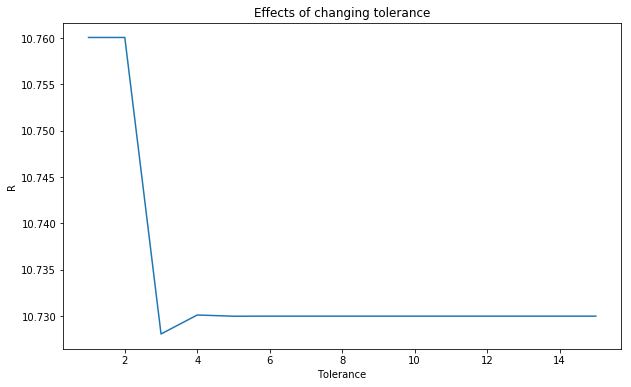

In [15]:
# Plotting obtained values of the gas constants
x_axis = np.linspace(1, 15, 15)
plt.figure(figsize=(10, 6))
plt.plot(x_axis, R_list)
plt.xlabel('Tolerance')
plt.ylabel('R')
plt.title('Effects of changing tolerance')
plt.show()

### Conclusions

* A density of the gas mixture in a gas reservoir can be received from the Compressibility Equation of State and Hall-Yarborough method of obtaining compressibility factor $Z$. After all the steps I received, that density is $\rho=10.34 \frac{lb}{ft^3}$ and compressibility factor is $Z=0.867$.

* If the tolerance is quite huge, e.g. from $10^{-1}$ to $10^{-3}$, the value of a gas constant $R$ is not stable and can change from $R=10.760\frac{psia \cdot ft^{3}}{lb-mol \cdot  R}$ to $R=10.725\frac{psia \cdot ft^{3}}{lb-mol \cdot  R}$. For tolerance $10^{-4}$ and bigger the value of $R$ does not change and equals to the standard value of $R=10.73\frac{psia \cdot ft^{3}}{lb-mol \cdot  R}$.

### References:
* Ahmed T. Reservoir Engineering Handbook. 4th Edition. 2010
* Ahmed T. Equations of State and PVT Analysis. 2nd Edition. 2016